In [1]:
import numpy as np
import scipy
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import filters as skifilters
from sklearn.ensemble import RandomForestClassifier
import h5py
import skimage.feature

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data

In [2]:
hdf5_path = "\\Users\carolina.cuesta-laza\Desktop\\"
filename = 'dataset_augmented_50.hdf5'
#filename = 'test.hdf5'

In [3]:
dataset = h5py.File(hdf5_path + filename, 'r')

In [4]:
print(dataset['train_label'].shape)

(383, 200, 200, 3)


### Make sure they look fine

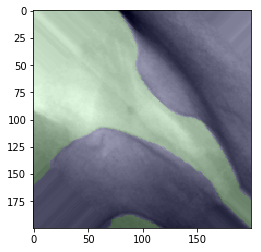

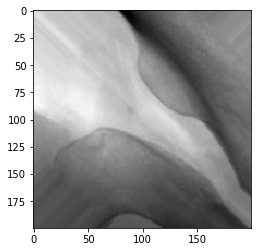

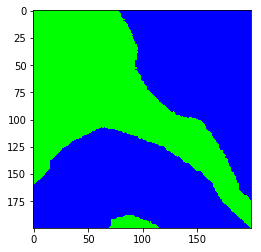

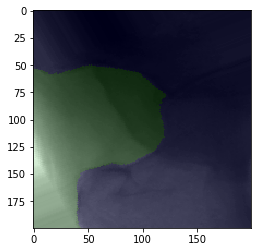

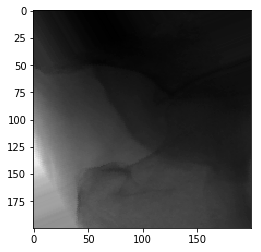

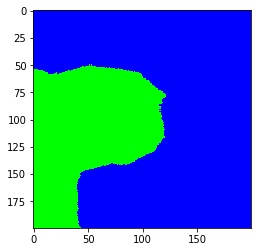

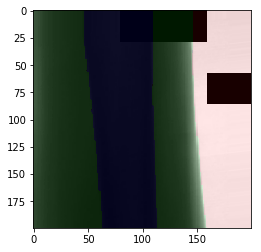

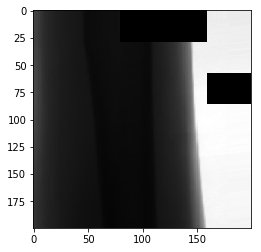

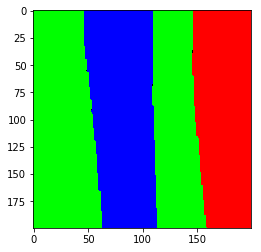

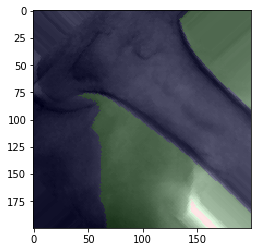

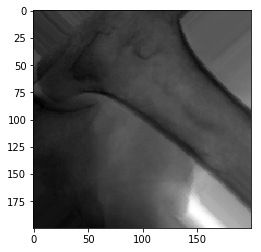

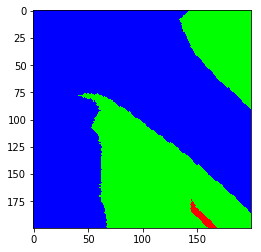

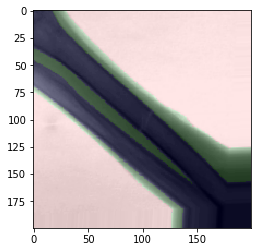

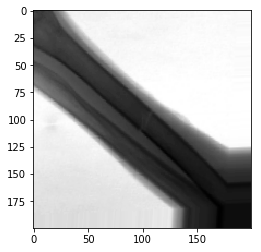

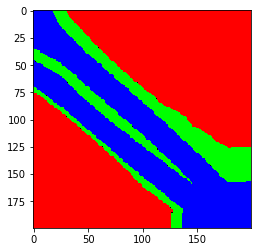

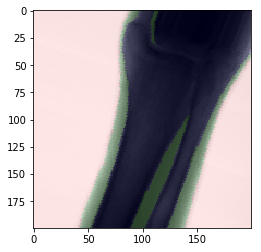

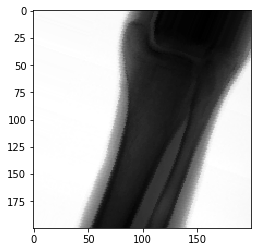

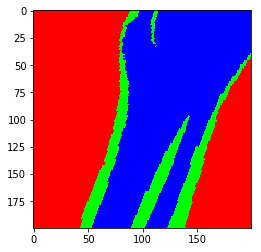

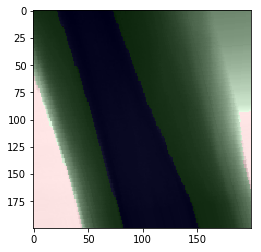

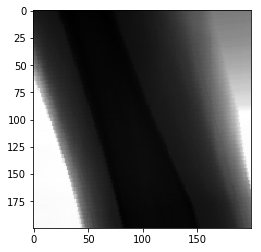

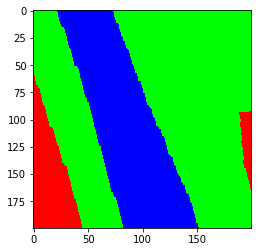

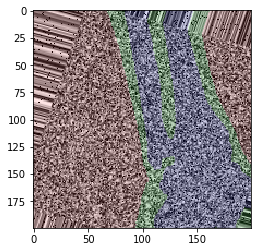

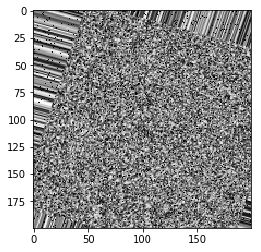

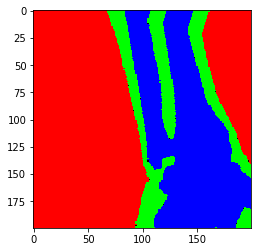

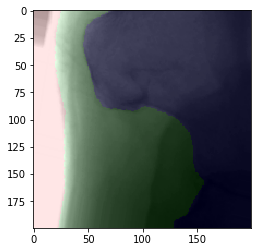

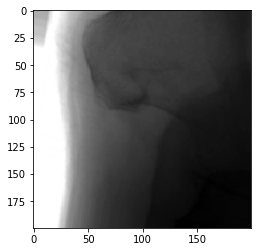

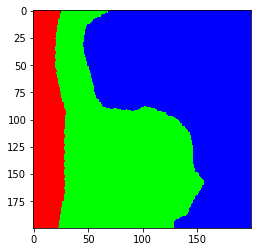

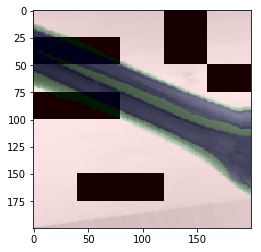

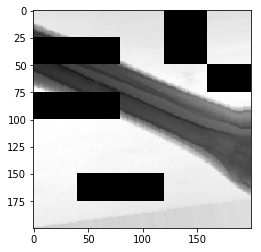

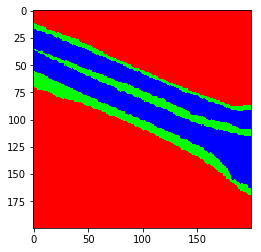

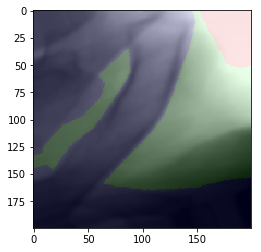

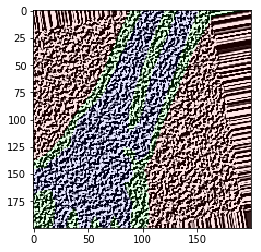

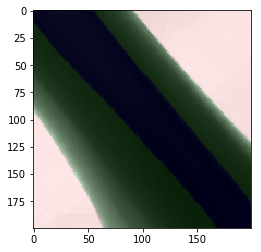

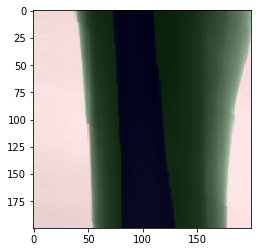

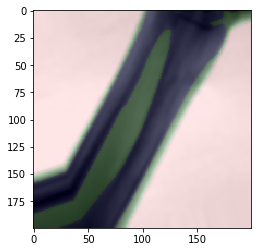

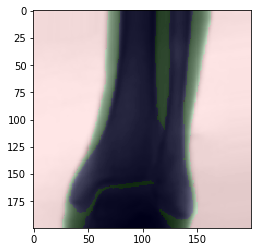

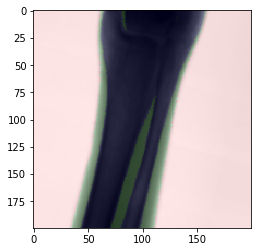

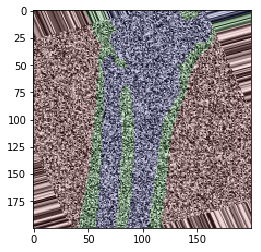

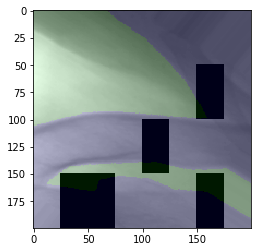

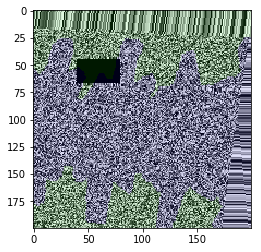

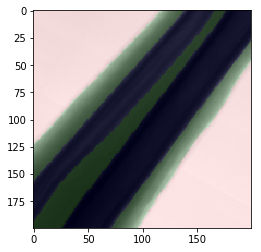

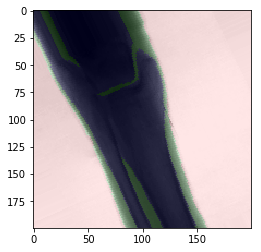

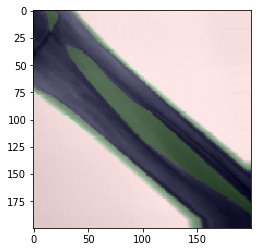

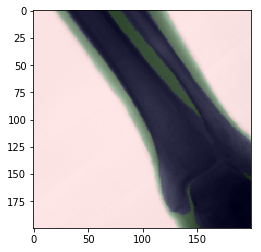

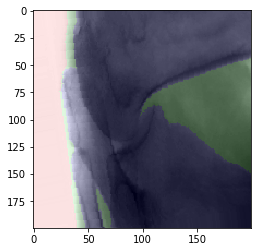

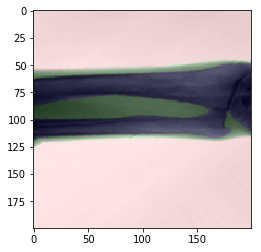

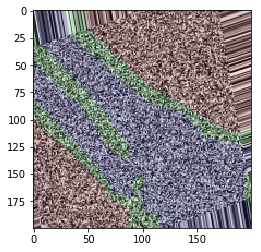

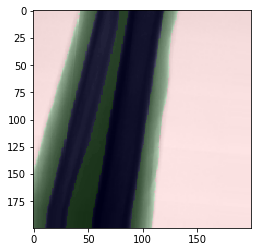

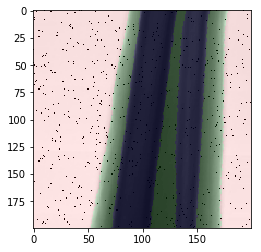

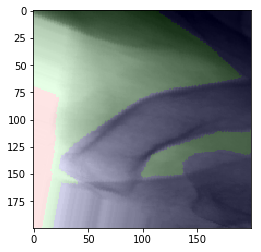

In [5]:
n =  10

for i in range(n):
    plt.imshow(dataset['train_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['train_label'][i,...],alpha=0.1)
    plt.show()
    plt.imshow(dataset['train_img'][i,...,0],cmap='gray')
    plt.show()
    plt.imshow(dataset['train_label'][i,...])
    plt.show()
    
for i in range(n):
    plt.imshow(dataset['val_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['val_label'][i,...],alpha=0.1)
    plt.show()
for i in range(n):
    plt.imshow(dataset['test_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['test_label'][i,...],alpha=0.1)
    plt.show()

# Features

In [6]:

def RandomGaussian(image,sigma=2.):
    ftg = skifilters.gaussian(image,sigma)
    #return np.reshape(ftg, (image.shape[0]*image.shape[1]*3))
    return ftg

def Laplacian(image):
    ftl = skifilters.laplace(image)
    #return np.reshape(ftl, (image.shape[0]*image.shape[1]*3))   
    return ftl

def HOG(image,orientations=8, pixels_per_cell=4, cells_per_block=1):
    fd, hog_image = skimage.feature.hog(image, orientations=orientations, pixels_per_cell=(pixels_per_cell, \
                    pixels_per_cell),cells_per_block=(cells_per_block, cells_per_block),visualise=True)
    return fd,hog_image

def canny(image, sigma=2., lthres=None, hthres=None):
    fc = skimage.feature.canny(image, sigma=1.0, low_threshold=None, high_threshold=None,\
                      mask=None, use_quantiles=False)
    return fc

def structure_tensor(image, sigma=2.):
    Axx, Axy, Ayy = skimage.feature.structure_tensor(image, sigma=sigma)
    eig = skimage.feature.structure_tensor_eigvals(Axx, Axy, Ayy)[0]
    return eig

def hessian(image,sigma=2.):
    # RETURNS ALL THE COMPONNETS! keep only last?
    fhess = skimage.feature.hessian_matrix(image, sigma=sigma, mode='constant', cval=0,order='xy')
    return fhess[-1]

def harris(image):
    # DOESN'T LOOK VERY PROMISING
    fharris = skimage.feature.corner_harris(image, method='k', k=0.5, eps=1e-08, sigma=2)
    return fharris

def median(image):
    fmed = skimage.filters.median(image, selem=None, out=None, mask=None, shift_x=False, shift_y=False)
    return fmed

def sobel(image):
    fsob = skimage.filters.sobel(image, mask=None)
    return fsob

def gabor(image):
    # Returns complex and imaginary
    fthres =  skimage.filters.gabor(image, frequency=0.6)
    return fthres

filters = ['image','gaussian', 'laplacian','HOG','canny','structure_tensor','hessian','harris','median','sobel',\
          'gabor_real','gabor_imaginary']
def apply_filters(x,y,images,labels,n_features):
    for i in range(images.shape[0]):
        pixel_init = i*dataset.attrs['image_size']*dataset.attrs['image_size']
        pixel_final = (i+1)*dataset.attrs['image_size']*dataset.attrs['image_size']
        x[pixel_init:pixel_final,0] = images[i,...,0].flatten()
        x[pixel_init:pixel_final,1] = RandomGaussian(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,2] = Laplacian(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,3] = HOG(images[i,...,0])[1].flatten()
        x[pixel_init:pixel_final,4] = canny(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,5] = structure_tensor(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,6] = hessian(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,7] = harris(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,8] = median(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,9] = sobel(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,10] = gabor(images[i,...,0])[0].flatten()
        x[pixel_init:pixel_final,11] = gabor(images[i,...,0])[1].flatten()
        y[pixel_init:pixel_final] = np.argmax(labels[i], axis=2, out=None).flatten()
    return x,y

# Visualize filters

c:\program files\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


gaussian


c:\program files\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


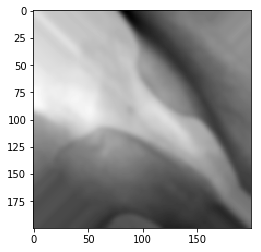

laplacian


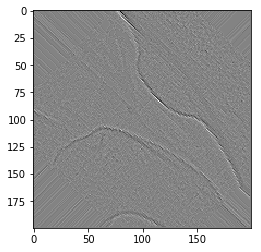

HOG


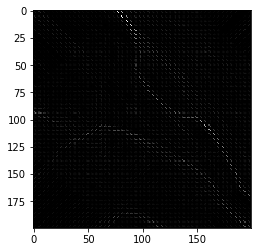

canny


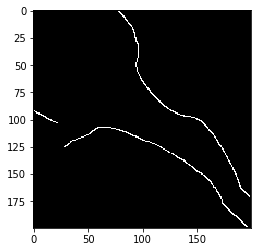

structure_tensor


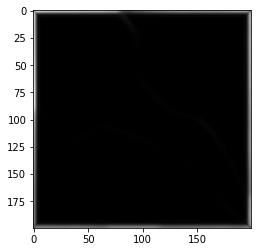

hessian


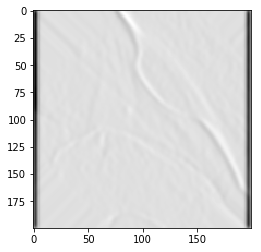

harris_corner


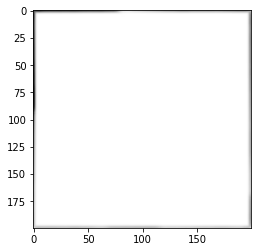

median


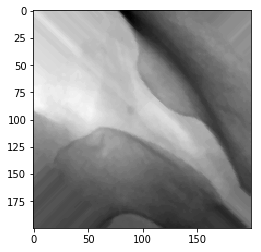

sobel


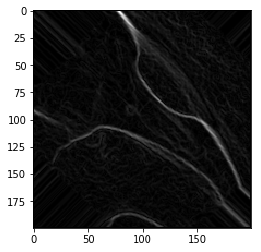

gabor_real


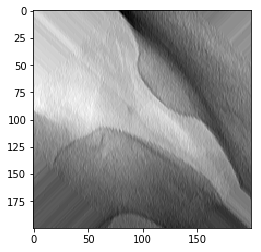

gabor_imaginary


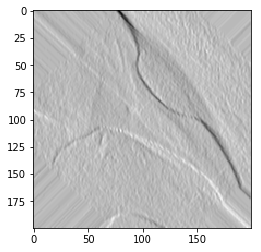

In [7]:
index = 0
visualize_image = dataset['train_img'][index,...,0]
filters_list = [RandomGaussian(visualize_image), Laplacian(visualize_image), HOG(visualize_image)[1],\
           canny(visualize_image), structure_tensor(visualize_image), hessian(visualize_image),\
           harris(visualize_image), median(visualize_image), sobel(visualize_image), gabor(visualize_image)[0],\
           gabor(visualize_image)[1]]
filters_names = ['gaussian','laplacian','HOG','canny','structure_tensor', 'hessian','harris_corner','median',\
                'sobel','gabor_real','gabor_imaginary']

for (i,f) in enumerate(filters_list):
    print(filters_names[i])
    plt.imshow(f,cmap='gray')
    plt.show()


# Create input for random forest

In [8]:
# Input data must has shape [n_samples, n_features]
n_features = len(filters_list) 
n_images = dataset['train_img'].shape[0]

x = np.empty((n_images*dataset.attrs['image_size']*dataset.attrs['image_size'], n_features+1))
# +1 for the actual image
y = np.empty((n_images*dataset.attrs['image_size']*dataset.attrs['image_size']))

x, y = apply_filters(x,y,dataset['train_img'], dataset['train_label'],n_features)


c:\program files\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
c:\program files\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


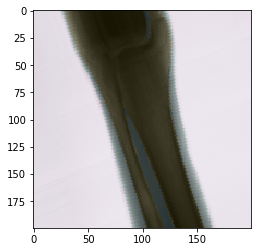

In [9]:
index_show = 203
plt.imshow(np.reshape(x[200*200*index_show:200*200*(index_show+1),0],(200,200)),cmap='gray')
plt.imshow(np.reshape(y[200*200*index_show:200*200*(index_show+1)],(200,200)),alpha=0.1)


In [10]:
n_test= dataset['test_img'].shape[0]

test_x = np.empty((n_test*dataset.attrs['image_size']*dataset.attrs['image_size'], n_features+1))
test_y = np.empty((n_test*dataset.attrs['image_size']*dataset.attrs['image_size']))
test_x, test_y = apply_filters(test_x,test_y,dataset['test_img'], dataset['test_label'],n_features)

c:\program files\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
c:\program files\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Train a random forest classifier

In [ ]:
RF = RandomForestClassifier(verbose=1,n_estimators=1000, min_samples_leaf=50,n_jobs=-1,oob_score=True)

RF.fit(x,y)

In [ ]:
train_accuracy = RF.score(x,y)

In [ ]:
test_accuracy = RF.score(test_x,test_y)

In [ ]:
print('Training acuracy :  %f' %train_accuracy)
print('Test acuracy :  %f' %test_accuracy)

In [ ]:
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
 
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

In [206]:
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
print(std)

[0.13655658 0.09073106 0.00616803 0.00044935 0.00024983 0.00562532
 0.00065555 0.00470692 0.14072502 0.01413785 0.08163413 0.00076108]


In [190]:
prediction = RF.predict(test_x)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


In [193]:
print(prediction.shape)

(3280000,)


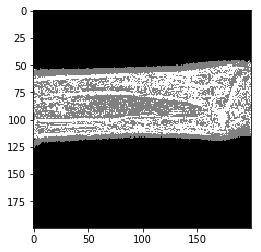

In [200]:
index_show = 5
plt.imshow(np.reshape(prediction[200*200*index_show:200*200*(index_show+1)],(200,200)),cmap='gray')
#plt.imshow(np.reshape(prediction,(200,200)),alpha=0.3)